In [1]:
import torch

In [3]:
torch.cuda.device(torch.cuda.current_device())

In [4]:
torch.cuda.get_device_name() # cpu name

'Tesla K80'

In [5]:
torch.cuda.is_available() # if gpu is available.

True

In [6]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader as DataLoader
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable

In [7]:
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


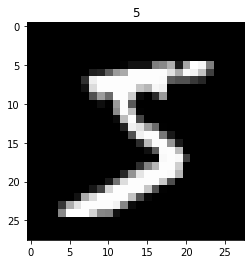

In [8]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset.data[0], cmap='gray') # first image
plt.title('%i' %train_dataset.targets[0])
plt.show()

In [9]:
batch_size = 100
num_class = 10 #label: 0-9
hidden_size = 500 
num_epoch = 5
learning_rate = 0.001

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False)

In [22]:
class  CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), # output_channels size 64 means filter count; kernel_size 3x3
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # image 28x28 -> 14x14
    ) 
    self.fc = nn.Sequential(
        nn.Linear(14*14*128, 1024), # 1024 is customizer hidden layer size 
        nn.ReLU(),
        nn.Dropout2d(p=0.5),
        nn.Linear(1024, 10)
    )

  def forward(self, x):
      out = self.conv(x)
      # need flat conv
      out = out.view(-1, 14*14*128)
      out = self.fc(out)
      return out

In [23]:
model = CNNModel()

In [24]:
# use GPU
model.cuda()

CNNModel(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=25088, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout2d(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [25]:
loss_func = nn.CrossEntropyLoss()
optimizer = opt.Adam(model.parameters(), lr=learning_rate)

In [27]:
# train
for epoch in range(num_epoch):
    for i, (images, labels) in enumerate(train_loader):
        # CPU version.
        # images = Variable(images) 
        # labels = Variable(labels) 

        # GPU version: turn type to GPU's tensor;
        images = Variable(images.type(torch.cuda.FloatTensor)) 
        labels = Variable(labels.type(torch.cuda.LongTensor)) 
        
        optimizer.zero_grad()
        output = model(images) # forward pass
        loss = loss_func(output, labels) # loss
        
        # backward
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch+1, i+1, loss.data))

Epoch: 1, Batch: 100, Loss: 0.1510525941848755
Epoch: 1, Batch: 200, Loss: 0.08885227143764496
Epoch: 1, Batch: 300, Loss: 0.1464851051568985
Epoch: 1, Batch: 400, Loss: 0.11307297646999359
Epoch: 1, Batch: 500, Loss: 0.030006565153598785
Epoch: 1, Batch: 600, Loss: 0.10731832683086395
Epoch: 2, Batch: 100, Loss: 0.17012006044387817
Epoch: 2, Batch: 200, Loss: 0.021586639806628227
Epoch: 2, Batch: 300, Loss: 0.06875664740800858
Epoch: 2, Batch: 400, Loss: 0.022066514939069748
Epoch: 2, Batch: 500, Loss: 0.07797355949878693
Epoch: 2, Batch: 600, Loss: 0.026158953085541725
Epoch: 3, Batch: 100, Loss: 0.031065018847584724
Epoch: 3, Batch: 200, Loss: 0.03753858432173729
Epoch: 3, Batch: 300, Loss: 0.01874089054763317
Epoch: 3, Batch: 400, Loss: 0.024350719526410103
Epoch: 3, Batch: 500, Loss: 0.016048461198806763
Epoch: 3, Batch: 600, Loss: 0.005924677476286888
Epoch: 4, Batch: 100, Loss: 0.0020047419238835573
Epoch: 4, Batch: 200, Loss: 0.017407339066267014
Epoch: 4, Batch: 300, Loss: 0.0

In [37]:
# calculate accuracy

correct = 0
total = 0
for images, labels in test_loader:    
    # GPU version
    output = model(images.type(torch.cuda.FloatTensor))
    
    # 1 means max by column;
    # _ is -> value; predicted -> label(index).
    _, predicted = torch.max(output.data, 1) 
    
    total += labels.size(0) # len; total is 100  here.
    correct += (predicted == labels.type(torch.cuda.FloatTensor)).sum() # turn labels to GPU version
    
print('accuracy: {} %'.format(float(correct)/ float(total) * 100))

accuracy: 98.81 %
